In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
_include_('curriculum_vqa')

from cvqa.curriculum import plotter, VQAInstanceDistribution2
from cvqa import trainers, datasets, viz

concept_dict = {
        'color': ['blue', 'brown', 'cyan', 'gray'],  # , 'green', 'purple', 'red', 'yellow'],
        'material': ['metal', 'rubber', 'plastic'],
        'shape': ['triangle', 'circle', 'square']
    }

vqa_dist = VQAInstanceDistribution2(concept_dict=concept_dict, prompt_types_filter=['retrieve_attribute'], d_img=24)
# vqa_dist = VQAInstanceDistribution2(concept_dict=concept_dict, prompt_types_filter=['exists', 'retrieve_attribute'], d_img=24)
# vqa_dist = VQAInstanceDistribution2(concept_dict=concept_dict, max_ref_concepts=2, d_img=24)

Img Encoder: Loss=0.001: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


In [3]:
# ds_temp = vqa_dist.sample_dataset(images=20, prompts_per_image=3)
# VQAInstanceDistribution2.to_debug_rep(ds_temp)

In [4]:
import random
import numpy as np
import torch
import torch.nn as nn

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

ds_train, ds_dev = datasets.Curriculum.from_samples(
    vqa_dist.sample_dataset(images=2000, prompts_per_image=5),
    vqa_dist.sample_dataset(images=200, prompts_per_image=5),
)

ds_train

Root: - 
Samples: 1883 (N_prompt=9, N_target=1)
Concepts: 0 
Classes: 0 
Prompt Vocab Tokens:22 
Answer Vocab Tokens:14 

In [5]:
trainer = trainers.VQATrainer(log_dir='runs')

def train_model(model, lr=1e-4, epochs=10, batch_size=32):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)
    
#     tracker = None
#     tracker = traintracks.TrainTracker(root='traintracks/eval')
#     tracker.save_module(sys.modules['cvqa.model_dev.f1_model'])
#     tracker.log_conf(model.args)

    train_loss, train_acc, dev_acc = trainer.train(
        model, ds_train, ds_dev, 
        optimizer, 
#         optim_sched=scheduler,
        num_epochs=epochs, 
        batch_size=batch_size
    )
    
    return {
        'train_loss': train_loss, 
        'train_acc': train_acc, 
        'dev_acc': dev_acc
    }

In [6]:
from cvqa.model_dev import parent

args = parent.default_args()
args['d_a'] = 4
args['d_w'] = args['d_c'] = 32
args['d_o'] = 24
args['d_k'] = 4

In [7]:
from cvqa.model_dev import answer_model

# def pretrain_answer_model(lr=3e-3, lr_decay_step_size=500, epochs=5, batch_size=32):

#     model = answer_model.ParentModel(ds_train.vocab, ds_train.ans_vocab, args)

#     trainer = trainers.VQATrainer()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=0.1)
    
#     train_loss, train_acc, dev_acc = trainer.train(
#         model, ds_train, ds_dev, 
#         optimizer, 
#         optim_sched=scheduler,
#         num_epochs=epochs, batch_size=batch_size
#     )
    
# #     viz.plot_training(train_loss, train_acc, dev_acc)
#     return model

# parent_a_model = pretrain_answer_model(epochs=5)
# model_a = parent_a_model.m_ans
# model_ctx = parent_a_model.context_model

# for p in parent_a_model.parameters(): p.requires_grad = False

In [8]:
from cvqa.model_dev import f1_model

# def pretrain_f1_model(lr=3e-3, epochs=15, batch_size=32):

#     seed = 2
#     np.random.seed(seed)
#     torch.manual_seed(seed)

#     model = f1_model.ParentModel(ds_train.vocab, ds_train.ans_vocab, args)
#     model.context_model = model_ctx
    
#     trainer = trainers.VQATrainer(
#         loss_fn=nn.NLLLoss(ignore_index=-1), 
#         pred_target='target_attention_mask', 
#         ignore_index=-1
#     )
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     train_loss, train_acc, dev_acc = trainer.train(
#         model, ds_train, ds_dev, 
#         optimizer,
#         num_epochs=epochs, batch_size=batch_size
#     )
    
# #     viz.plot_training(train_loss, train_acc, dev_acc)
#     return model.m_f1

# model_f1 = pretrain_f1_model(epochs=15)

# for p in model_f1.parameters(): p.requires_grad = False

In [16]:
import numpy as np
from cvqa.model_dev.programs import ProgramSpec, Seq2ConstTreeModel, TransformerSeederModel, Seq2VecsLSTM

def build_parent_model(prompt_vocab, answer_vocab):
    model_a = answer_model.AnswerModule(parent.parse_dims_dict(args), answer_vocab)
    model_f1 = f1_model.F1ModuleSimple(args)
        
    program_spec = ProgramSpec({
        'A': model_a,
        'F': model_f1
    })
    seq2tree = Seq2ConstTreeModel(program_spec.vocab, 'A ( F )')
    
#     program_spec = ProgramSpec({
#         'M': parent.MultiModule(args['d_w'], [model_a, model_f1])
#     })
#     seq2tree = Seq2ConstTreeModel(program_spec.vocab, 'M ( M )')
    
#     seeder_model = TransformerSeederModel(prompt_vocab, program_spec.vocab, args)
    
    seeder_args = Seq2VecsLSTM.args(prompt_vocab, program_spec.vocab)
    seeder_args['d_target'] = args['d_w']
    seeder_model = Seq2VecsLSTM(seeder_args)
    
    context_model = parent.ContextModel(args, answer_vocab)
#     context_model = model_ctx

    return parent.MyModel(seq2tree, seeder_model, program_spec, context_model)

[epoch=49, steps=2892, train_acc=1.00, dev_acc=0.99] loss: 0.011: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


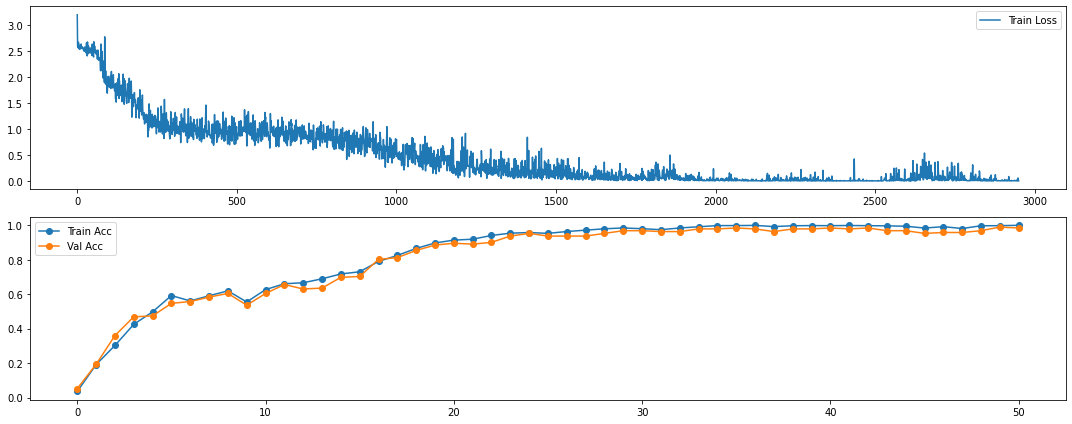

In [19]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

model = build_parent_model(ds_train.vocab, ds_train.ans_vocab)
train_metrics = train_model(model, lr=2e-3, epochs=50, batch_size=32)
viz.plot_training(**train_metrics)

In [136]:
# for tag, parm in model.named_parameters():
#     if parm.requires_grad: 
#         print(tag)
# list(model.parameters())

list(model.modules())

[MyModel(
   (seeder_model): Seq2VecsLSTM(
     (E_input): Embedding(22, 16)
     (encoder_lstm): LSTM(16, 16, num_layers=2)
     (decoder_lstm): LSTM(4, 16, num_layers=2)
     (W_o): Linear(in_features=16, out_features=32, bias=True)
     (E_decoder): Embedding(9, 4)
   )
   (context_model): ContextModel(
     (img_layer_norm): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
     (W_viz): Sequential(
       (0): Linear(in_features=24, out_features=24, bias=True)
       (1): ReLU()
       (2): Linear(in_features=24, out_features=32, bias=True)
       (3): ReLU()
     )
     (img_feat_layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
   )
   (node_A): AnswerModule(
     (CW_ans): CondLinear()
     (E_a): Embedding(14, 4)
   )
   (node_F): F1ModuleSimple(
     (W_concepts): Sequential(
       (0): Linear(in_features=32, out_features=32, bias=True)
     )
   )
 ),
 Seq2VecsLSTM(
   (E_input): Embedding(22, 16)
   (encoder_lstm): LSTM(16, 16, num_layers=2)
   (decoder_

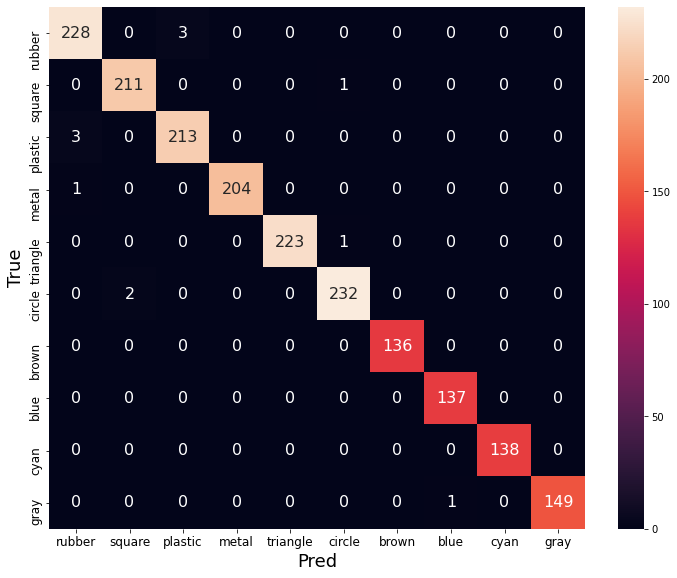

In [45]:
y_true, y_pred = trainer.get_predictions(model, ds_train)
viz.one_word_conf_mat(y_true, y_pred, ds_dev.ans_vocab)

In [8]:
# y_true, y_pred = trainer.get_predictions(model, ds_dev)
# viz.one_word_conf_mat(y_true, y_pred, ds_dev.ans_vocab)

In [9]:
np.set_printoptions(precision=2, suppress=True)

def show_some_predictions(ds, count=3):
    ds_with_idxs = datasets.WithIndicesDataset(ds)
    loader = torch.utils.data.DataLoader(ds_with_idxs, batch_size=1)
    with torch.no_grad():
        for i, s in enumerate(loader):
            if i >= count:
                break
            probs = model.forward_test(s)[1]
            full_sample = ds.samples[s['index']]
            print(full_sample['debug_info']['SCENE '])
            print(full_sample['debug_info']['PROMPT'])
            print('TRUE: ' + str(s['target_attention_mask'].numpy().flatten()))
            print('PRED: ' + str(probs.numpy().flatten()))
            print()
        
show_some_predictions(ds_train)

[['0' 'blue rubber triangle']
 ['1' 'gray rubber circle']]
How many gray rubber circles are there ? --> 1
TRUE: [ 0  1 -1 -1 -1 -1 -1]
PRED: [0.   0.98 0.   0.   0.   0.   0.  ]

[['1' 'blue rubber triangle']
 ['0' 'gray rubber circle']]
What material is the blue triangle ? --> rubber
TRUE: [ 1  0 -1 -1 -1 -1 -1]
PRED: [0.94 0.   0.   0.   0.   0.   0.  ]

[['0' 'blue rubber triangle']
 ['0' 'gray rubber circle']]
Are there 1 metal items ? --> False
TRUE: [ 0  0 -1 -1 -1 -1 -1]
PRED: [0. 0. 0. 0. 0. 0. 0.]

